# MOPITT Carbon Monoxide (CO) Mixing Ratio

## Summary

## Note
By: Cheyenne Land

Tested using Python 3.8.10

## 1. Setup

In [ ]:
import numpy as np
import h5py
from matplotlib import pyplot as PLT
import cartopy.crs as ccrs
import PIL

## 2. Open and read file

The file must be in the same directory.

In [ ]:
FILE_NAME = 'MOP03JM-202001-L3V95.9.3.he5'
with h5py.File(FILE_NAME, mode='r') as f:
    name = '/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOMixingRatioProfileDay'

    # Slice data to get the pressure level of your choice
    #   [Longitude(Xdim):360 , Latitude(Ydim):180, Presure level:9]
    #   Pressure Level: 0 = 900 hPa, 1 = 800 hPa, 2 = 700 hPa, 3 = 600 hPa
    #   4 = 500 hPa, 5 = 400 hpa, 6 = 300 hPa, 7 = 200 hPa, 8 = 100 hPa
    d = f[name][:]
    data = np.transpose(d)

    # Retrieve the lat and lon data as well as the area of your choice
    lon = f['/HDFEOS/GRIDS/MOP03/Data Fields/Longitude'][:]
    lat = f['/HDFEOS/GRIDS/MOP03/Data Fields/Latitude'][:]

    # Turn the -9999.0 into a NaN
    masked_data = np.ma.masked_where(data <= 0, data)
    CO_mixing_ratio = data.copy()
    CO_mixing_ratio[masked_data <= 0] = np.nan

    pressure_levels = np.arange(0,9)

## 3. Plot all graphs in a for loop

In [ ]:
for i in pressure_levels:
    PLT.figure(figsize=(7.20,3.60))
    ax = PLT.axes(projection=ccrs.PlateCarree())
    im = PLT.contourf(lon, lat, CO_mixing_ratio[i,:,:], 300,
                      cmap=PLT.get_cmap('jet'), vmin=0, vmax=600,
                      levels=np.arange(0,700, 100),
                      transform=ccrs.PlateCarree())
    ax.coastlines()

    cb = PLT.colorbar(im, shrink = 0.76)
    cb.set_label('ppbv', fontsize=8)
    pressure = -i + 9
    PLT.title('MOP03JM-202001-L3V95.9.3_RetrievedCOMixingRatioProfileDay_'+str(pressure)+'00hPa',
              fontsize=8)

    # save the figure in your current directory
    PLT.savefig("MOP03JM-202001-L3V95.9.3_RetrievedCOMixingRatioProfileDay_"+str(pressure)+"00hPa.jpg",
                dpi=200)
    PLT.close()
    PLT.clf()

## 4. Create gif

Source: GeoDelta Labs.(2020, March 22).
How to create an animated time-lapse of temperature using netCDF grid data
        [Video File]. https://www.youtube.com/watch?v=dSv3-obKv3M

In [ ]:
frames = []
pressure = np.arange(1,10)[::-1]

for j in pressure:
    new_frame = PIL.Image.open(r'MOP03JM-202001-L3V95.9.3_RetrievedCOMixingRatioProfileDay_'+str(j)+'00hPa.jpg')
    frames.append(new_frame)

frames[0].save('RetrievedCOMixingRatioProfileDay_PressureLevels.gif', format = 'GIF',
               append_images = frames[:], save_all = True, duration = 250,
               loop = 0)

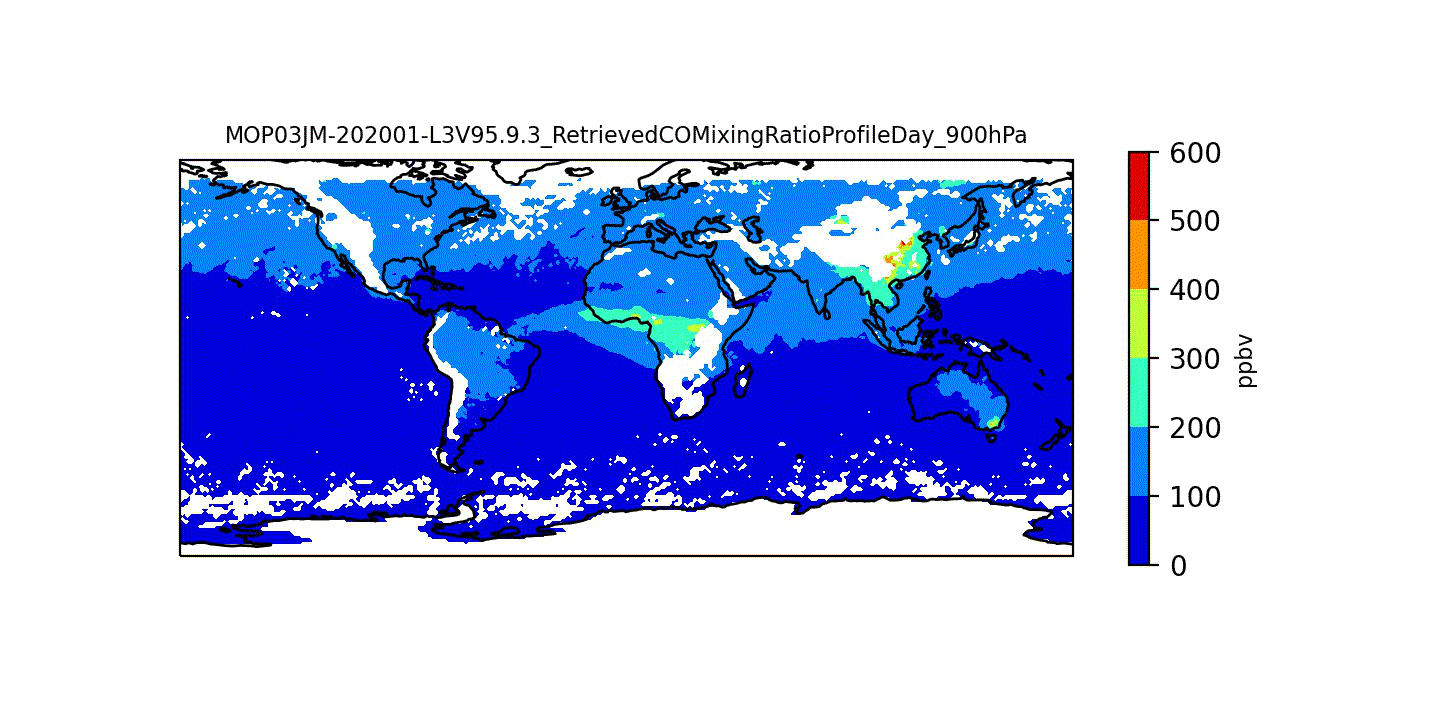